In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras import layers, models, applications, regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, classification_report

# Checar se tem GPU disponível

In [2]:
print("Num GPUs Disp:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Disp: 1


In [3]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Ativa a primeira GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        device = '/GPU:0'
        print("✅ Usando GPU")
    except RuntimeError as e:
        print("⚠️ Erro ao configurar GPU:", e)
        device = '/CPU:0'
else:
    print("❌ GPU não disponível, usando CPU")
    device = '/CPU:0'

✅ Usando GPU


# Criando a estrutura do projeto

In [4]:
IA_path = os.path.join('data','IA') #caminho das imagens geradas por IA
Real_path = os.path.join('data','Real') #caminho das imagens de pessoas reais

#criando pastas
os.makedirs(IA_path, exist_ok=True)
os.makedirs(Real_path, exist_ok=True)

# Pré-Processamento das Imagens e Divisão Train/Test/Val

In [5]:
# --- Constants ---
IMG_SIZE = (100, 100)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Preprocessing images (central crop + resize) ---
def preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    # image = tf.image.resize_with_crop_or_pad(image, 160, 160)
    image = tf.image.central_crop(image, central_fraction=0.8)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# --- Data Augmentation (only for training) ---
def augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.2)
    x = tf.image.random_contrast(x, 0.8, 1.2)
    return x, y

# --- Load filepaths separately ---
ia_files = tf.data.Dataset.list_files(IA_path + '/*.jpg', shuffle=True)
real_files = tf.data.Dataset.list_files(Real_path + '/*.jpg', shuffle=True)

# --- Map to (image, label) ---
ia_ds = ia_files.map(lambda x: (preprocess(x), tf.constant(1)), num_parallel_calls=AUTOTUNE)
real_ds = real_files.map(lambda x: (preprocess(x), tf.constant(0)), num_parallel_calls=AUTOTUNE)

# --- Balance classes using sample_from_datasets ---
balanced_ds = tf.data.Dataset.sample_from_datasets([real_ds, ia_ds], weights=[0.5, 0.5])
balanced_ds = balanced_ds.shuffle(500, seed=42)

# --- Split manually ---
total_samples = 163233  
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)

train_ds = balanced_ds.take(train_size).map(augment, num_parallel_calls=AUTOTUNE)
val_test_ds = balanced_ds.skip(train_size)

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

# --- Batch and prefetch ---
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Exemplos do Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.033930987..1.1800735].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2184143..1.0634134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16169834..1.0495183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09711617..0.6762821].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10679817..1.099148].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03587866..1.1131365].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015468

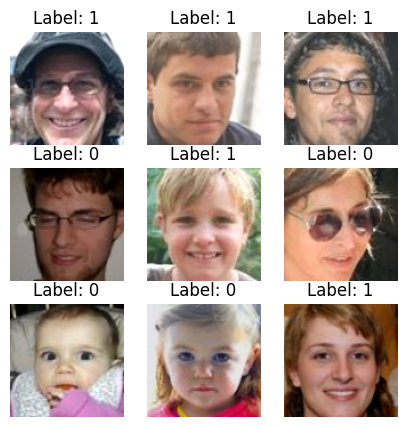

In [6]:
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy() # -> 1 - IA, 0 - Real
    
    plt.figure(figsize=(5, 5))
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i]) 
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

# Construção do Modelo Pré-treinado 1 - MobileNetV2

In [7]:
# --- Model (MobileNetV2 base) ---
base_model = applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 164,097
Non-tr

In [8]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)

In [9]:
# --- Train ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping_cb, reduce_lr_cb]
)

Epoch 1/10
3571/3571 [==============================] - 122s 32ms/step - loss: 0.5657 - accuracy: 0.7220 - val_loss: 0.5078 - val_accuracy: 0.7609 - lr: 1.0000e-04
Epoch 2/10
3571/3571 [==============================] - 114s 32ms/step - loss: 0.5163 - accuracy: 0.7521 - val_loss: 0.4905 - val_accuracy: 0.7717 - lr: 1.0000e-04
Epoch 3/10
3571/3571 [==============================] - 117s 33ms/step - loss: 0.5009 - accuracy: 0.7629 - val_loss: 0.4801 - val_accuracy: 0.7772 - lr: 1.0000e-04
Epoch 4/10
3571/3571 [==============================] - 117s 33ms/step - loss: 0.4907 - accuracy: 0.7690 - val_loss: 0.4660 - val_accuracy: 0.7827 - lr: 1.0000e-04
Epoch 5/10
3571/3571 [==============================] - 115s 32ms/step - loss: 0.4821 - accuracy: 0.7750 - val_loss: 0.4552 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 6/10
3571/3571 [==============================] - 117s 33ms/step - loss: 0.4766 - accuracy: 0.7766 - val_loss: 0.4507 - val_accuracy: 0.7916 - lr: 1.0000e-04
Epoch 7/10
3571/

# Resultados

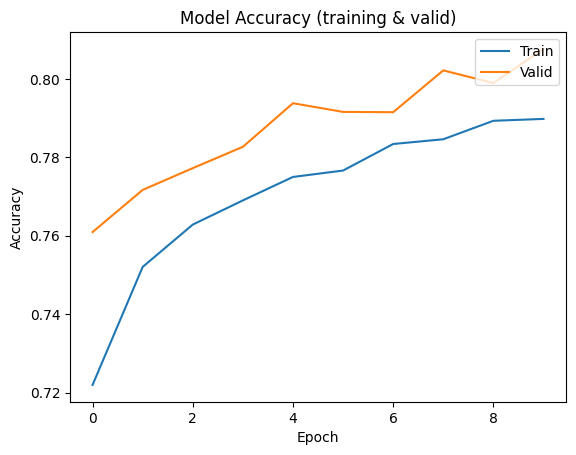

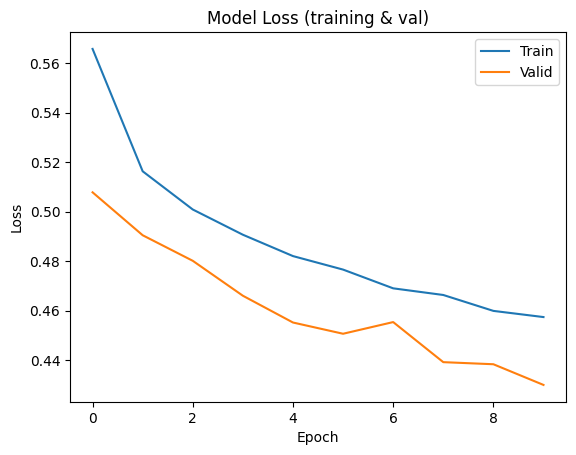

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

# Testando no Conjunto de Teste

In [11]:
loss, acc = model.evaluate(test_ds)
print(f"Test accuracy: {acc:.4f}")

766/766 [==============================] - 50s 20ms/step - loss: 0.4286 - accuracy: 0.8085
Test accuracy: 0.8085


# Métricas

In [14]:
# true_labels = test_ds.classes

# # matriz de confusão
# plt.figure(figsize = (8,5))
# sklearn.metrics.confusion_matrix(true_labels, predicted_labels.round())
# plt.show()

# Obter todas as imagens e rótulos reais
# all_images = []
# all_labels = []

# for images, labels in test_ds:
#     all_images.append(images.numpy())
#     all_labels.append(labels.numpy())

# # Concatena tudo
# X_test = np.concatenate(all_images)
# y_true = np.concatenate(all_labels)

# Faz predições com o modelo (saída é probabilidade)
y_probs = model.predict(test_ds)
y_pred = (y_probs > 0.5).astype(int).reshape(-1)

766/766 [==============================] - 43s 18ms/step


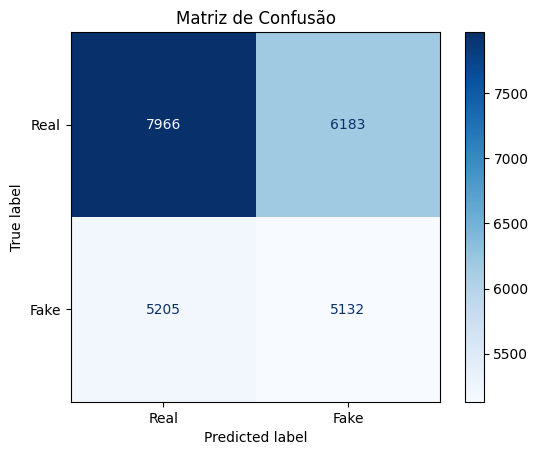

In [15]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão")
plt.show()

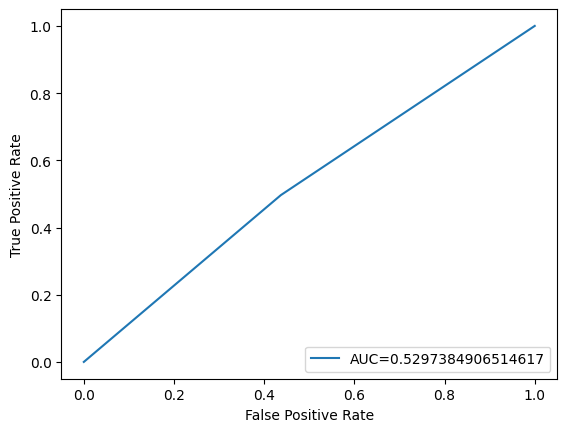

In [16]:
#curva ROC
fpr, tpr, _ = roc_curve(y_true,  y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))